## Import Necessary Modules

In [ ]:
!pip install wordcloud

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install neattext

In [4]:
import boto3
import re
import string
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

get_ipython().magic('matplotlib inline')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 100)

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS, tokenization
import neattext as nt
import neattext.functions as nfx

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
get_ipython().magic('matplotlib inline')

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

## Read in Data

In [3]:
#Gather data from s3 bucket
bucketname = 'YOUR BUCKET NAME HERE'
filename = 'script_EDA_file.csv'

s3 = boto3.resource('s3')
s3.Bucket(bucketname).download_file(filename, '../script_EDA_file.csv')

In [8]:
df = pd.read_csv("../script_EDA_file.csv")

In [5]:
#Drop first column
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
#View data info
df.info()

## Data Cleaning

In [7]:
#Remove unneccesary characters from text
df['text'] = df['text'].apply(lambda x: re.sub("[^\w\d' ]", ' ', x))

In [8]:
#Split scripts by words
df['text'] = df['text'].str.split()

In [9]:
#Create Movie title column
df["movie_title"] = df["file_name"].apply(lambda x: x.split(".")[0].replace("_", " "))

In [10]:
#Pull last couple of words from script to extract genre
df['Genres'] = df['text'].apply(lambda x: x[-40:])

In [11]:
# Separate Genre into a separate column

def pull_genre(column):
    newlst = []
    [newlst.append(column[i + 1]) for i, word in enumerate(column) if word == "Genres"]
    return newlst

df['genre'] = df['Genres'].apply(lambda x: pull_genre(x))

df.drop(columns = ['Genres'], axis = 1, inplace = True)

df['genre'] = df['genre'].apply(lambda x: x[0])

In [12]:
#Split Genre into Lists
def split_genres(genres):
    return re.sub( r"([A-Z])", r" \1", genres).split()

df['genre'] = df['genre'].apply(lambda x: split_genres(str(x)))

In [ ]:
df.head()

In [15]:
#binarize genre data
from sklearn.preprocessing import MultiLabelBinarizer

# Binarise labels
mlb = MultiLabelBinarizer()
expandedGenreData = mlb.fit_transform(df["genre"])
labelClasses = mlb.classes_


# Create a pandas.DataFrame from our output
expandedGenres = pd.DataFrame(expandedGenreData, columns=labelClasses)

In [16]:
#concat dataframes back together
df_concat = pd.concat([df, expandedGenres], axis=1)

In [18]:
def remove_caps(text):
    regex = re.compile(r"(\b[A-Z]+\b)")
    caps = list(filter(regex.match, text))
    no_caps = [x for x in text if x not in caps]
    return no_caps

df_concat['text'] = df_concat['text'].apply(lambda x: remove_caps(x))

In [46]:
df_concat.rename(columns={'Film': 'Film-Noir', 'Sci': 'Sci-Fi'}, inplace=True)

In [60]:
df_concat.head()

,file_name,text,movie_title,genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Beasts_of_No_Nation.txt,NaN,Beasts of No Nation,"[Drama, War]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Beauty_and_the_Beast.txt,NaN,Beauty and the Beast,"[Family, Fantasy, Musical]",0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Beavis_and_Butt-head_Do_America.txt,NaN,Beavis and Butt-head Do America,"[Animation, Comedy]",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beginners.txt,NaN,Beginners,"[Comedy, Drama, Romance]",0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Being_Human.txt,NaN,Being Human,"[Comedy, Drama, Fantasy]",0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
#Create new csv file with changes
df_concat.to_csv('no_caps_script.csv', index = False)

## Data Cleaning Pt. 2 

In [120]:
df2 = pd.read_csv('../no_caps_script.csv')

In [121]:
#Lowercase strings
df2['text'] = df2['text'].str.lower()

In [122]:
#Delist text column for preprocessing purposes
df2['text'] = df2['text'].apply(eval).apply(' '.join)

In [123]:
df2.head()

,file_name,text,movie_title,genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Beasts_of_No_Nation.txt,written by cary joji fukunaga based on the novel by uzodinma iweala may 8th 2014 the dialogue in this screenplay is faithful in form to the novel originally written in a lighter form of nigerian pidgin english known as krio krio and its various dialects is used as a lingua franca throughout west africa from the gambia to cameroon and is spoken by millions the accented of 10 it is starting like...,Beasts of No Nation,"['Drama', 'War']",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Beauty_and_the_Beast.txt,written by stephen chbosky evan spiliotopoulos based on the 1991 animated film beauty and the beast screenplay by linda woolverton august 10 2016 1 1 resplendent bespeaking great wealth and power the grounds and stonework immaculate once upon a time in the hidden heart of france a handsome young prince lived in a beautiful castle to a single clinging to a rose bush on a stormy spring night plu...,Beauty and the Beast,"['Family', 'Fantasy', 'Musical']",0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Beavis_and_Butt-head_Do_America.txt,beavis and butt head do america by mike judge and joe stillman b b if window top top location href location href b b by mike judge and joe stillman the movie begins with scenes of people screaming in horror and running down the streets of a big city the ground shakes from what seems like giant footsteps there are pieces of building debris falling everywhere people getting crushed power lines c...,Beavis and Butt-head Do America,"['Animation', 'Comedy']",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beginners.txt,written by mike mills single daisy stands in a vase in an empty kitchen clicks on the light to the closet he looks at the rack of his parents' clothes he begins to put some in a box marked home some in a box marked thrift oliver enters the bathroom and flushes bottle after bottle of pills and liquids down the toilet next he struggles as he looks over the old toothbrush hairbrush all the bottle...,Beginners,"['Comedy', 'Drama', 'Romance']",0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Being_Human.txt,written by bill forsyth january 1992 1992 4000 warner boulevard burbank california 91522 all rights reserved and as he stared at the sky and listened to a cow mooing almost dreamily in a distant village he tried to understand what it all meant the sky and the fields and the humming telegraph pole he felt that he was just at the point of understanding it when his head started to spin and the lu...,Being Human,"['Comedy', 'Drama', 'Fantasy']",0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Removing Stop Words

In [124]:
## setting stopwords and punctuations
import string, re

stop_words_list = stopwords.words('english')
stop_words_list += list(string.punctuation)
stop_words_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'hand', 'written', 'com', '-', '–', '—', 'come', 'take', 'got', 'head', 'hand']
stop_words_list += ["b", "look", "s", "nt", "like", "re", "door", "know", "away", "back", 'looks', "n't", 'takes', 'right']
stop_words_list += ['turns', 'want', 'going', 'looking', 'takes', 'face', 'hands', 'll', 'room', 'good', 'eyes']

stop_words_set = set(stop_words_list)

In [125]:
# we can define a function that removes stopwords 
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words_set]
    return stopwords_removed 

# applying the above function to our text column
df2['text'] = df2['text'].apply(lambda x: remove_stopwords(x))

In [126]:
df2.to_csv("../no_stop_words.csv", index = False)

### Stemming

In [127]:
df3 = pd.read_csv("../no_stop_words.csv")

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 400)

In [128]:
df3.head()

,file_name,text,movie_title,genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Beasts_of_No_Nation.txt,"['cary', 'joji', 'fukunaga', 'based', 'novel', 'uzodinma', 'iweala', 'may', '8th', '2014', 'dialogue', 'screenplay', 'faithful', 'form', 'novel', 'originally', 'lighter', 'form', 'nigerian', 'pidgin', 'english', 'known', 'krio', 'krio', 'various', 'dialects', 'used', 'lingua', 'franca', 'throughout', 'west', 'africa', 'gambia', 'cameroon', 'spoken', 'millions', 'accented', '10', 'starting', 'a...",Beasts of No Nation,"['Drama', 'War']",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Beauty_and_the_Beast.txt,"['stephen', 'chbosky', 'evan', 'spiliotopoulos', 'based', '1991', 'animated', 'film', 'beauty', 'beast', 'screenplay', 'linda', 'woolverton', 'august', '10', '2016', '1', '1', 'resplendent', 'bespeaking', 'great', 'wealth', 'power', 'grounds', 'stonework', 'immaculate', 'upon', 'time', 'hidden', 'heart', 'france', 'handsome', 'young', 'prince', 'lived', 'beautiful', 'castle', 'single', 'clingi...",Beauty and the Beast,"['Family', 'Fantasy', 'Musical']",0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Beavis_and_Butt-head_Do_America.txt,"['beavis', 'butt', 'america', 'mike', 'judge', 'joe', 'stillman', 'window', 'top', 'top', 'location', 'href', 'location', 'href', 'mike', 'judge', 'joe', 'stillman', 'movie', 'begins', 'scenes', 'people', 'screaming', 'horror', 'running', 'streets', 'big', 'city', 'ground', 'shakes', 'seems', 'giant', 'footsteps', 'pieces', 'building', 'debris', 'falling', 'everywhere', 'people', 'getting', 'c...",Beavis and Butt-head Do America,"['Animation', 'Comedy']",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beginners.txt,"['mike', 'mills', 'single', 'daisy', 'stands', 'vase', 'empty', 'kitchen', 'clicks', 'light', 'closet', 'rack', 'parents', 'clothes', 'begins', 'put', 'box', 'marked', 'home', 'box', 'marked', 'thrift', 'oliver', 'enters', 'bathroom', 'flushes', 'bottle', 'bottle', 'pills', 'liquids', 'toilet', 'next', 'struggles', 'old', 'toothbrush', 'hairbrush', 'bottles', 'tubes', 'besides', 'sink', 'stare...",Beginners,"['Comedy', 'Drama', 'Romance']",0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Being_Human.txt,"['bill', 'forsyth', 'january', '1992', '1992', '4000', 'warner', 'boulevard', 'burbank', 'california', '91522', 'rights', 'reserved', 'stared', 'sky', 'listened', 'cow', 'mooing', 'almost', 'dreamily', 'distant', 'village', 'tried', 'understand', 'meant', 'sky', 'fields', 'humming', 'telegraph', 'pole', 'felt', 'point', 'understanding', 'started', 'spin', 'lucid', 'languor', 'moment', 'became'...",Being Human,"['Comedy', 'Drama', 'Fantasy']",0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [129]:
#Delist text column for preprocessing purposes
df3['text'] = df3['text'].apply(eval).apply(' '.join)

In [130]:
#Remove digits
def remove_digits(text):
    text = re.sub('\w*\d\w*', "", text)
    return text

df3['text'] = df3['text'].apply(remove_digits)

In [131]:
df3.head()

,file_name,text,movie_title,genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Beasts_of_No_Nation.txt,cary joji fukunaga based novel uzodinma iweala may dialogue screenplay faithful form novel originally lighter form nigerian pidgin english known krio krio various dialects used lingua franca throughout west africa gambia cameroon spoken millions accented starting angle plastic exterior screen less television see children running circles football pitch angle boy balancing warm smile clever ...,Beasts of No Nation,"['Drama', 'War']",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Beauty_and_the_Beast.txt,stephen chbosky evan spiliotopoulos based animated film beauty beast screenplay linda woolverton august resplendent bespeaking great wealth power grounds stonework immaculate upon time hidden heart france handsome young prince lived beautiful castle single clinging rose bush stormy spring night plucks rose although everything heart desired prince selfish unkind groomed servants see face...,Beauty and the Beast,"['Family', 'Fantasy', 'Musical']",0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Beavis_and_Butt-head_Do_America.txt,beavis butt america mike judge joe stillman window top top location href location href mike judge joe stillman movie begins scenes people screaming horror running streets big city ground shakes seems giant footsteps pieces building debris falling everywhere people getting crushed power lines coming etc complete pandemonium much japanese animated king kong godzilla movie hear footsteps getting ...,Beavis and Butt-head Do America,"['Animation', 'Comedy']",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beginners.txt,mike mills single daisy stands vase empty kitchen clicks light closet rack parents clothes begins put box marked home box marked thrift oliver enters bathroom flushes bottle bottle pills liquids toilet next struggles old toothbrush hairbrush bottles tubes besides sink stares beat throws oliver hauls trash outside adding large pile bags older jack russell terrier follows oliver arthur sit offic...,Beginners,"['Comedy', 'Drama', 'Romance']",0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Being_Human.txt,bill forsyth january warner boulevard burbank california rights reserved stared sky listened cow mooing almost dreamily distant village tried understand meant sky fields humming telegraph pole felt point understanding started spin lucid languor moment became intolerable vladimir nabokov script six main characters inhabit different periods time pre history present day one story blend one de...,Being Human,"['Comedy', 'Drama', 'Fantasy']",0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# portstem = PorterStemmer()

In [ ]:
# # creating a list with all lemmatized outputs
# stemmed_output = []

# for listy in processed_data:
#     stemmed = ' '.join([portstem.stem(w) for w in listy])
#     stemmed_output.append(lemmed)

### Lemmitization

In [86]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("enters"))

enters


In [132]:
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokens]

lemm_text = df3['text'].apply(lemmatize_text)

In [133]:
df3.head()

,file_name,text,movie_title,genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Beasts_of_No_Nation.txt,cary joji fukunaga based novel uzodinma iweala may dialogue screenplay faithful form novel originally lighter form nigerian pidgin english known krio krio various dialects used lingua franca throughout west africa gambia cameroon spoken millions accented starting angle plastic exterior screen less television see children running circles football pitch angle boy balancing warm smile clever ...,Beasts of No Nation,"['Drama', 'War']",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Beauty_and_the_Beast.txt,stephen chbosky evan spiliotopoulos based animated film beauty beast screenplay linda woolverton august resplendent bespeaking great wealth power grounds stonework immaculate upon time hidden heart france handsome young prince lived beautiful castle single clinging rose bush stormy spring night plucks rose although everything heart desired prince selfish unkind groomed servants see face...,Beauty and the Beast,"['Family', 'Fantasy', 'Musical']",0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Beavis_and_Butt-head_Do_America.txt,beavis butt america mike judge joe stillman window top top location href location href mike judge joe stillman movie begins scenes people screaming horror running streets big city ground shakes seems giant footsteps pieces building debris falling everywhere people getting crushed power lines coming etc complete pandemonium much japanese animated king kong godzilla movie hear footsteps getting ...,Beavis and Butt-head Do America,"['Animation', 'Comedy']",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beginners.txt,mike mills single daisy stands vase empty kitchen clicks light closet rack parents clothes begins put box marked home box marked thrift oliver enters bathroom flushes bottle bottle pills liquids toilet next struggles old toothbrush hairbrush bottles tubes besides sink stares beat throws oliver hauls trash outside adding large pile bags older jack russell terrier follows oliver arthur sit offic...,Beginners,"['Comedy', 'Drama', 'Romance']",0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Being_Human.txt,bill forsyth january warner boulevard burbank california rights reserved stared sky listened cow mooing almost dreamily distant village tried understand meant sky fields humming telegraph pole felt point understanding started spin lucid languor moment became intolerable vladimir nabokov script six main characters inhabit different periods time pre history present day one story blend one de...,Being Human,"['Comedy', 'Drama', 'Fantasy']",0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [134]:
df3.to_csv('../lemm_data.csv', index = False)

### Frequency Distribution

In [135]:
df_lemm = pd.read_csv('../lemm_data.csv')

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 400)

In [136]:
df_lemm.head()

,file_name,text,movie_title,genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Beasts_of_No_Nation.txt,cary joji fukunaga based novel uzodinma iweala may dialogue screenplay faithful form novel originally lighter form nigerian pidgin english known krio krio various dialects used lingua franca throughout west africa gambia cameroon spoken millions accented starting angle plastic exterior screen less television see children running circles football pitch angle boy balancing warm smile clever ...,Beasts of No Nation,"['Drama', 'War']",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Beauty_and_the_Beast.txt,stephen chbosky evan spiliotopoulos based animated film beauty beast screenplay linda woolverton august resplendent bespeaking great wealth power grounds stonework immaculate upon time hidden heart france handsome young prince lived beautiful castle single clinging rose bush stormy spring night plucks rose although everything heart desired prince selfish unkind groomed servants see face...,Beauty and the Beast,"['Family', 'Fantasy', 'Musical']",0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Beavis_and_Butt-head_Do_America.txt,beavis butt america mike judge joe stillman window top top location href location href mike judge joe stillman movie begins scenes people screaming horror running streets big city ground shakes seems giant footsteps pieces building debris falling everywhere people getting crushed power lines coming etc complete pandemonium much japanese animated king kong godzilla movie hear footsteps getting ...,Beavis and Butt-head Do America,"['Animation', 'Comedy']",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beginners.txt,mike mills single daisy stands vase empty kitchen clicks light closet rack parents clothes begins put box marked home box marked thrift oliver enters bathroom flushes bottle bottle pills liquids toilet next struggles old toothbrush hairbrush bottles tubes besides sink stares beat throws oliver hauls trash outside adding large pile bags older jack russell terrier follows oliver arthur sit offic...,Beginners,"['Comedy', 'Drama', 'Romance']",0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Being_Human.txt,bill forsyth january warner boulevard burbank california rights reserved stared sky listened cow mooing almost dreamily distant village tried understand meant sky fields humming telegraph pole felt point understanding started spin lucid languor moment became intolerable vladimir nabokov script six main characters inhabit different periods time pre history present day one story blend one de...,Being Human,"['Comedy', 'Drama', 'Fantasy']",0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# df_lemm['text'].values

In [14]:
# script_text

In [86]:
#Delist text column for preprocessing purposes
# df_lemm['text'] = df_lemm['text'].apply(eval).apply(' '.join)

# df_lemm['text'] = df_lemm['text'].apply(lambda x: " ".join(x))

In [137]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=5, stop_words="english")
df_cv = cv.fit_transform(df_lemm.text)
df_dtm = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_lemm.movie_title
df_dtm

,__,_a,aa,aaa,aaaa,aaaaa,aaaaaaaah,aaaaaaah,aaaaah,aaaah,aaaahhh,aaaahhhh,aaagh,aaah,aaahh,aaargh,aagh,aah,aahh,aahhh,aahs,aaron,ab,aback,abacus,...,zit,zo,zodiac,zoe,zoloft,zombie,zombies,zone,zoned,zones,zoning,zonked,zoo,zoological,zoom,zoomed,zooming,zooms,zoot,zorro,zucchini,zulu,zurich,zwei,zy
movie_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Beasts of No Nation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0
Beauty and the Beast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Beavis and Butt-head Do America,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Beginners,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Being Human,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Battle of Shaker Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Battle: Los Angeles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
Bean,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [163]:

df_dtm.columns

Index(['__', '_a', 'aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaah', 'aaaaaaah',
       'aaaaah', 'aaaah',
       ...
       'zoomed', 'zooming', 'zooms', 'zoot', 'zorro', 'zucchini', 'zulu',
       'zurich', 'zwei', 'zy'],
      dtype='object', length=39501)

In [29]:
# cv.get_feature_names()

['__',
 '___',
 '____',
 '_____',
 '______',
 '_______',
 '________',
 '__________',
 '____________',
 '_____________',
 '______________',
 '__________________',
 '____________________',
 '_____________________',
 '______________________',
 '_____________________________',
 '_______________________________',
 '_____________________________________________________________',
 '______________________________________________________________________________',
 '__________________________________________scene',
 '______int',
 '__ctle',
 '__e',
 '__ex__',
 '__f',
 '__few',
 '__he_r',
 '__rible',
 '__shooting',
 '__the',
 '_a',
 '_a_',
 '_a_small_indentation_at_the_top_',
 '_aaliz_s',
 '_aashell',
 '_all',
 '_all_',
 '_another',
 '_answer_',
 '_anything_',
 '_as',
 '_bank',
 '_battle_',
 '_beore',
 '_best',
 '_birth',
 '_bonehead_',
 '_buenos_aires_',
 '_burke',
 '_but_there_is_no_one_there_',
 '_c',
 '_calendar_on_the_wall_',
 '_cc',
 '_certificates',
 '_cm',
 '_coes',
 '_continuous',
 '_conv

In [138]:
import pickle
# Let's pickle it for later use
df_dtm.to_pickle("../dtm.pkl")

In [10]:
def freqdist(ex):
    fdist = nltk.FreqDist(ex)
    for word in fdist:
        print(f'{word}: {fdist[word]}')

In [11]:
ex = ["yo", "yo", "yo", "hey", "what's", "up", "up"]

In [12]:
freqdist(ex)

yo: 3
hey: 1
what's: 1
up: 2


In [21]:
# df_lemm['text'].apply(freqdist)

In [ ]:
# df3['freqdist'] = df3['text'].apply(freqdist)

## Visualizing Data

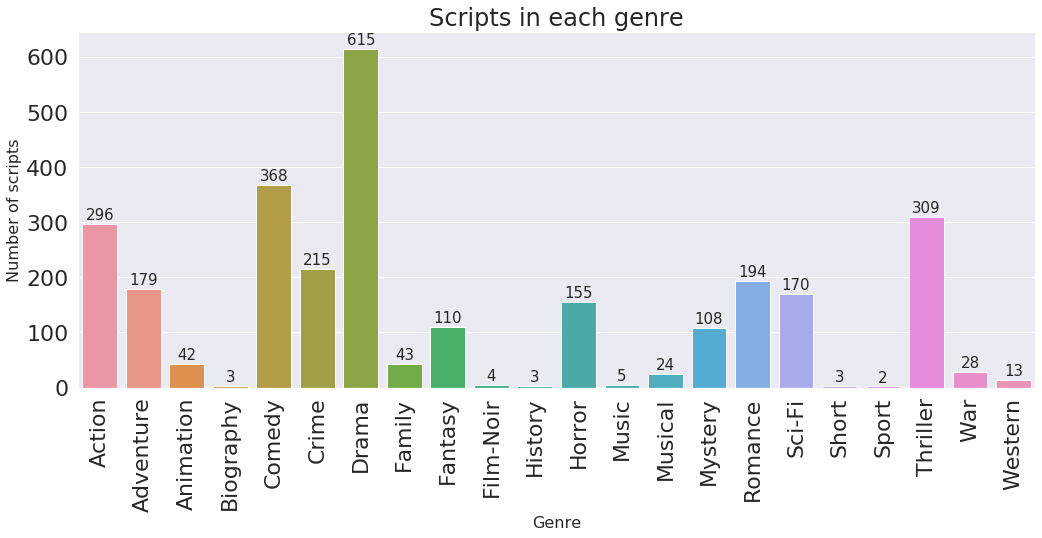

In [94]:
#Barplot for amount of scripts in each genre
categories = list(df_lemm.columns[4:].values)
sns.set(font_scale = 2, style = 'darkgrid')
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, df_lemm.iloc[:,4:].sum().values)
plt.title("Scripts in each genre", fontsize=24)
plt.ylabel('Number of scripts', fontsize=16)
plt.xlabel('Genre', fontsize=16)

ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='center')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                size = 15,
                xytext = (0, 9),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

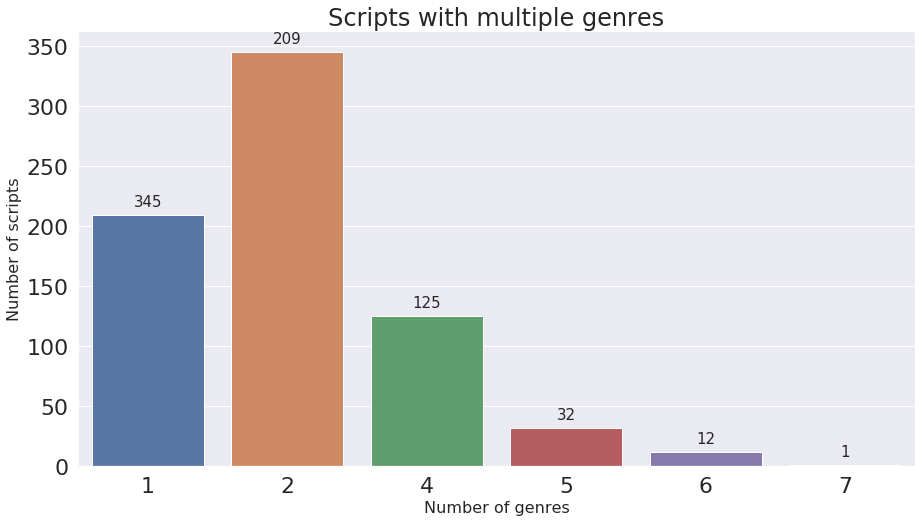

In [95]:
#Barplot for scripts that have multiple genres
rowSums = df_lemm.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Scripts with multiple genres")
plt.ylabel('Number of scripts', fontsize=16)
plt.xlabel('Number of genres', fontsize=16)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, 
            label, ha='center', va='bottom', size=15)
plt.show()

### Train-Test-Split

In [96]:
!pip install neattext

In [97]:
import neattext as nt
import neattext.functions as nfx

In [40]:
# df_lemm['text'].apply(lambda x:nt.TextExtractor(x).extract_stopwords())

In [39]:
# df_lemm['text'].apply(nfx.remove_stopwords)

In [40]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [139]:
df_lemm['text'] = df_lemm['text'].apply(nfx.remove_multiple_spaces)

In [140]:
script_corpus = df_lemm['text'].apply(nfx.clean_text)

In [141]:
X = script_corpus
y = df_lemm.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

In [142]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [143]:
print("X Train Shape:", X_train.shape)
print("Y Train Shape:", y_train.shape)
print("X Test Shape:", X_test.shape)
print("Y Test Shape:", y_test.shape)

X Train Shape: (855,)
Y Train Shape: (855, 22)
X Test Shape: (286,)
Y Test Shape: (286, 22)


In [97]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(df_lemm, random_state=42, test_size=0.25, shuffle=True)

# print("Train Shape:", train.shape)
# print("Test Shape:", test.shape)

In [19]:
# train_text = train['text']
# test_text = test['text']

### TF-IDF

In [144]:
tfidf = TfidfVectorizer(ngram_range=(1,3), norm='l2')

tfidf_train_lem = tfidf.fit_transform(X_train)
tfidf_test_lem = tfidf.transform(X_test)

tfidf_train_lem

<855x12048639 sparse matrix of type '<class 'numpy.float64'>'
	with 16822651 stored elements in Compressed Sparse Row format>

In [145]:
non_zero_cols = tfidf_train_lem.nnz / float(tfidf_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 19675.61520467836
Percentage of columns containing ZERO: 0.9983669844200097


In [17]:
# stop_words_set = set(stopwords.words('english'))

In [59]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(ngram_range=(1,3), norm='l2', stop_words=stop_words_set)
# vectorizer.fit(train_text)
# vectorizer.fit(test_text)

In [21]:
# X_train = vectorizer.transform(train_text)
# y_train = train.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

# X_test = vectorizer.transform(test_text)
# y_test = test.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

### Wordcloud

In [146]:
df_drama = df_lemm[df_lemm['Drama']==1]
df_comedy = df_lemm[df_lemm['Comedy']==1]
df_action = df_lemm[df_lemm['Action']==1]
df_thriller = df_lemm[df_lemm['Thriller']==1]

In [147]:
drama_text = df_drama['text']
comedy_text = df_comedy['text']
action_text = df_action['text']
thriller_text = df_thriller['text']

In [ ]:
# stop_words_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
#             'hand', 'written', 'com', '-', '–', '—', 'come', 'take', 'got', 'head', 'hand']
# stop_words_list += ["b", "look", "s", "nt", "like", "re", "door", "know", "away", "back", 'looks', "n't", 'takes', 'right']
# stop_words_list += ['turns', 'want', 'going', 'looking', 'takes', 'face', 'hands', 'll', 'room', 'good', 'eyes']

In [148]:
# docx = nfx.TextFrame(mytext)
# docx.remove_stopwords(lang='en')

def new_clean(words):
    docx = nfx.TextFrame(words)
    docx.remove_stopwords(lang='en')
    docx.remove_multiple_spaces
    docx.remove_special_characters
    docx.remove_numbers
    docx.remove_puncts()
    docx.remove_custom_words(["b", "look", "s", "nt", "like", "re", "door", "know", "away", "back", 'looks', "n't", 'takes', 'right'])
    docx.remove_custom_words(['turns', 'want', 'going', 'looking', 'takes', 'face', 'hands', 'll', 'room', 'good', 'eyes'])
    docx.remove_custom_words(["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'hand', 'written', 'com', '-', '–', '—', 'come', 'take', 'got', 'head', 'hand'])
    return docx

In [149]:
script_drama = list(map(new_clean, drama_text))
script_comedy = list(map(new_clean, comedy_text))
script_action = list(map(new_clean, action_text))
script_thriller = list(map(new_clean, thriller_text))

In [119]:
#Delist text column for preprocessing purposes
# df_lemm['text'] = df_lemm['text'].apply(eval).apply(' '.join)
# script_drama.apply(lambda x: " ".join(x))

In [150]:
# Preprocessing:
# We will use these again later on
# FORMAT:  flat_list = [item for sublist in l for item in sublist]

flat_drama = [sublist for sublist in script_drama]
flat_comedy = [sublist for sublist in script_comedy]
flat_action = [sublist for sublist in script_action]
flat_thriller = [sublist for sublist in script_thriller]

In [151]:
drama_token = nltk.word_tokenize(str(flat_drama))
comedy_token = nltk.word_tokenize(str(flat_comedy))
action_token = nltk.word_tokenize(str(flat_action))
thriller_token = nltk.word_tokenize(str(flat_thriller))

In [152]:
drama_freq = FreqDist(drama_token)
comedy_freq = FreqDist(comedy_token)
action_freq = FreqDist(action_token)
thriller_freq = FreqDist(thriller_token)

In [153]:
# Top 20 thriller words:

thriller_freq.most_common(25)

[('man', 10537),
 ('car', 9603),
 ('time', 8208),
 ('think', 7743),
 ('way', 7690),
 ('open', 7070),
 ('phone', 6920),
 ('pulls', 6856),
 ('beat', 6804),
 ('walks', 6229),
 ('d', 6161),
 ('starts', 5872),
 ('let', 5818),
 ('tell', 5676),
 ('goes', 5644),
 ('little', 5601),
 ('gun', 5408),
 ('sees', 5376),
 ('window', 5317),
 ('comes', 5311),
 ('floor', 5273),
 ('sits', 5257),
 ('gets', 5195),
 ('na', 5140),
 ('long', 5089)]

In [157]:
# create counts of satire and not satire with values and words
drama_bar_counts = [x[1] for x in drama_freq.most_common(25)]
drama_bar_words = [x[0] for x in drama_freq.most_common(25)]

comedy_bar_counts = [x[1] for x in comedy_freq.most_common(25)]
comedy_bar_words = [x[0] for x in comedy_freq.most_common(25)]

action_bar_counts = [x[1] for x in action_freq.most_common(25)]
action_bar_words = [x[0] for x in action_freq.most_common(25)]

thriller_bar_counts = [x[1] for x in thriller_freq.most_common(25)]
thriller_bar_words = [x[0] for x in thriller_freq.most_common(25)]

In [158]:
# set the color of our bar graphs
color = cm.winter_r(np.linspace(.4,.8, 30))

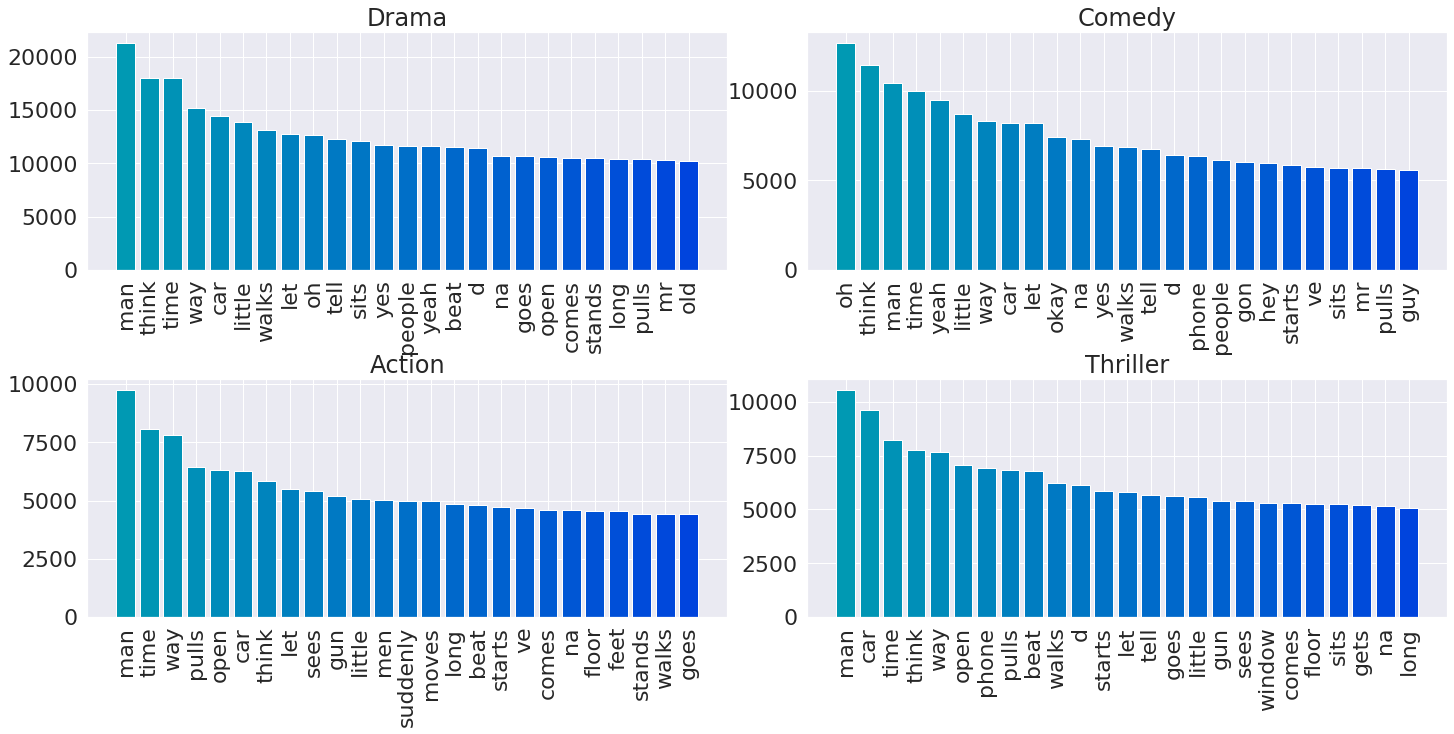

In [160]:
new_figure = plt.figure(figsize=(20,10))

ax = new_figure.add_subplot(221)
ax2 = new_figure.add_subplot(222)
ax3 = new_figure.add_subplot(223)
ax4 = new_figure.add_subplot(224)


# Generate a line plot on first axes
ax.bar(drama_bar_words, drama_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(comedy_bar_words, comedy_bar_counts, color=color)

# Draw a scatter plot on 3rd axes
ax3.bar(action_bar_words, action_bar_counts, color=color)

# Draw a scatter plot on 4th axes
ax4.bar(thriller_bar_words, thriller_bar_counts, color=color)


ax.title.set_text('Drama')
ax2.title.set_text('Comedy')
ax3.title.set_text('Action')
ax4.title.set_text('Thriller')


for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)


plt.tight_layout(pad=0)
# plt.yscale()
plt.savefig('../word_count_bar_graphs.png')

plt.show()

In [ ]:
# ['right', 'turns', 'want', 'going', 'looking', 'takes', 'face', 'hands', 'll', 'room', 'good', 'eyes']

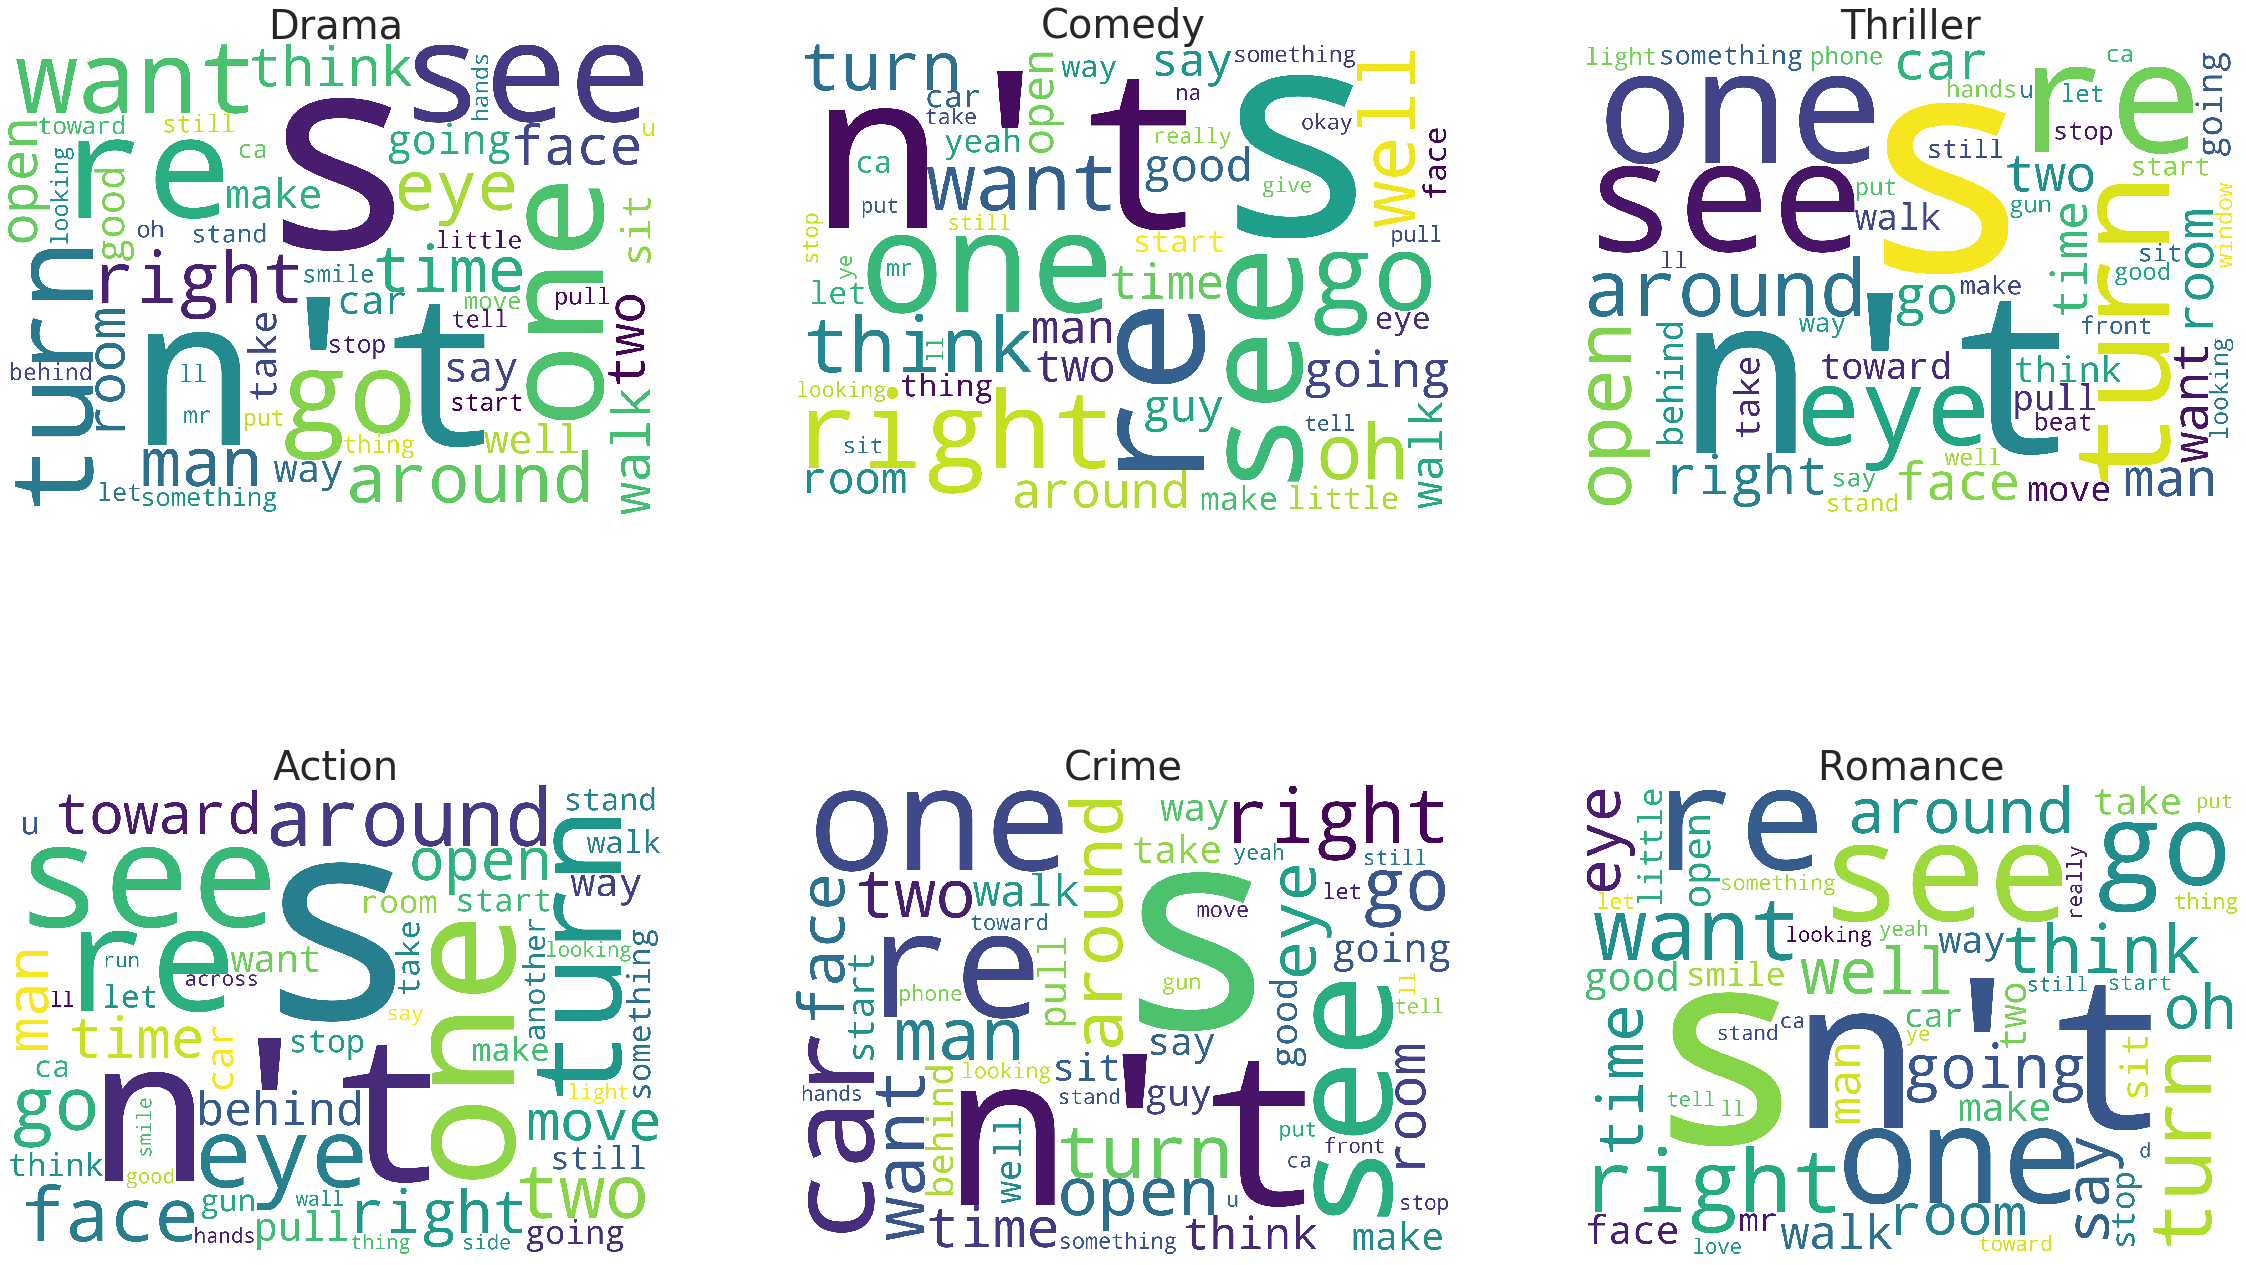

In [118]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# drama
subset = df_lemm[df_lemm.Drama==1]
text = [line for line in subset.text.values]
cloud_drama = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        collocations=False,
                        max_words=50,
                        width=2500,
                        height=1800).generate(str(text))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("Drama",fontsize=40)
plt.imshow(cloud_drama)


# comedy
subset = df_lemm[df_lemm.Comedy==1]
text = [line for line in subset.text.values]
cloud_comedy = WordCloud(stopwords=STOPWORDS,
                         background_color='white',
                         collocations=False,
                         max_words=50,
                         width=2500,
                         height=1800).generate(str(text))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Comedy",fontsize=40)
plt.imshow(cloud_comedy)



# Thriller
subset = df_lemm[df_lemm.Thriller==1]
text = [line for line in subset.text.values]
cloud_thriller = WordCloud(stopwords=STOPWORDS,
                           background_color='white',
                           collocations=False,
                           max_words=50,
                           width=2500,
                           height=1800).generate(str(text))

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("Thriller",fontsize=40)
plt.imshow(cloud_thriller)


# action
subset = df_lemm[df_lemm.Action==1]
text = [line for line in subset.text.values]
cloud_action = WordCloud(stopwords=STOPWORDS,
                         background_color='white',
                         collocations=False,
                         max_words=50,
                         width=2500,
                         height=1800).generate(str(text))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Action",fontsize=40)
plt.imshow(cloud_action)


# crime
subset = df_lemm[df_lemm.Crime==1]
text = [line for line in subset.text.values]
cloud_crime = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        collocations=False,
                        max_words=50,
                        width=2500,
                        height=1800).generate(str(text))

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Crime",fontsize=40)
plt.imshow(cloud_crime)


# romance
subset = df_lemm[df_lemm.Romance==1]
text = [line for line in subset.text.values]
cloud_romance = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          max_words=50,
                          width=2500,
                          height=1800).generate(str(text))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Romance",fontsize=40)
plt.imshow(cloud_romance)

plt.show()

## Modeling

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix 
from sklearn.multiclass import OneVsRestClassifier

In [62]:
categories = list(df_lemm.columns.values)
categories = categories[4:]
print(categories)

['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


### Logistic Regression Pipeline

In [67]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])

for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting logistic regression model on train data
    LogReg_pipeline.fit(tfidf_train_lem, y_train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(tfidf_test_lem)
    print('Testing accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
#     print('F1 score is {}'.format(f1_score(test[category], prediction)))
#     print(classification_report(test[category], prediction))
    print("\n")

Processing Action scripts
Testing accuracy is 0.7412587412587412


Processing Adventure scripts
Testing accuracy is 0.8601398601398601


Processing Animation scripts
Testing accuracy is 0.958041958041958


Processing Biography scripts
Testing accuracy is 0.993006993006993


Processing Comedy scripts
Testing accuracy is 0.6573426573426573


Processing Crime scripts
Testing accuracy is 0.7902097902097902


Processing Drama scripts
Testing accuracy is 0.6608391608391608


Processing Family scripts
Testing accuracy is 0.9755244755244755


Processing Fantasy scripts
Testing accuracy is 0.8951048951048951


Processing Film-Noir scripts
Testing accuracy is 1.0


Processing History scripts
Testing accuracy is 0.9965034965034965


Processing Horror scripts


OSError: [Errno 12] Cannot allocate memory

In [72]:
print(len(y_test[category]))

286


In [73]:
print(len(prediction))

286


### Multinomial Naive Bayes Pipeline

In [29]:
%%time

# Define a pipeline combining a text feature extractor with multi label classifier
NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])


for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting Naive Bayes model on train data
    NB_pipeline.fit(tfidf_train_lem, y_train)
    
    # calculating test accuracy
    prediction = NB_pipeline.predict(tfidf_test_lem)
    print('Testing accuracy is {}'.format(accuracy_score(y_test, prediction)))
    print("\n")

Processing Action scripts
Testing accuracy is 0.7412587412587412


Processing Adventure scripts
Testing accuracy is 0.8601398601398601


Processing Animation scripts
Testing accuracy is 0.958041958041958


Processing Biography scripts
Testing accuracy is 0.993006993006993


Processing Comedy scripts
Testing accuracy is 0.6503496503496503


Processing Crime scripts
Testing accuracy is 0.7902097902097902


Processing Drama scripts
Testing accuracy is 0.6363636363636364


Processing Family scripts
Testing accuracy is 0.9755244755244755


Processing Fantasy scripts
Testing accuracy is 0.8951048951048951


Processing Film-Noir scripts
Testing accuracy is 1.0


Processing History scripts
Testing accuracy is 0.9965034965034965


Processing Horror scripts
Testing accuracy is 0.8566433566433567


Processing Music scripts
Testing accuracy is 0.993006993006993


Processing Musical scripts
Testing accuracy is 0.9790209790209791


Processing Mystery scripts
Testing accuracy is 0.9090909090909091




### Gaussian Naive Bayes

In [32]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 4.3 MB/s eta 0:00:011


In [33]:
%%time

# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
GNB = BinaryRelevance(GaussianNB())

for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting Naive Bayes model on train data
    GNB.fit(tfidf_train_lem, y_train)

    # calculating test accuracy
    prediction = GNB.predict(tfidf_test_lem)
    print('Testing accuracy is {}'.format(accuracy_score(y_test, prediction)))
    print("\n")

Processing Action scripts


AttributeError: 'Series' object has no attribute 'reshape'